# Data Analysis for MultiClaim Sample Data

In [1]:
from time import time
import seaborn as sns
import matplotlib.pyplot as plt
from src.datasets import TextConcatPosts, TextConcatFactCheck
import pandas as pd

POSTS_PATH = "data/complete_data/posts.csv"
FACT_CHECKS_PATH = "data/complete_data/fact_checks.csv"
TASKS_PATH = "data/splits/tasks.json"
GS_PATH = "data/complete_data/pairs.csv"
PHASE1_TASKS_PATH = "data/complete_data/tasks.json"
OUTPUT_PATH = "out"
LANGS = ['eng', 'fra', 'deu', 'por', 'spa', 'tha',  'msa', 'ara']

TASK_NAME = "monolingual"
LANG = "eng"

time_start = time()
posts = TextConcatPosts(POSTS_PATH, TASKS_PATH, task_name=TASK_NAME, gs_path=GS_PATH, lang=LANG)
print(f"Loaded {len(posts)}")
print(f"Time taken: {time() - time_start:.2f}s\n")

print("Loading fact checks..")
time_start = time()
fact_checks = TextConcatFactCheck(FACT_CHECKS_PATH, TASKS_PATH, task_name=TASK_NAME, lang=LANG)
print(f"Loaded {len(fact_checks)}")
print(f"Time taken: {time() - time_start:.2f}s\n")

Loaded 4829
Time taken: 0.75s

Loading fact checks..
Loaded 85734
Time taken: 6.62s



# Total Number of Posts and Fact Checks by Tasks

**Observations:**
- Checking English training data, we can see that there are some training samples that are not in English but their lang columns is in English.
- 153,743 fact checks; 24,431 posts; 25,743 post-fact-checks pairs
- No overlap between the training and test data and between languages

In [176]:
df_posts_total = posts.df
df_train_en = df_posts_total.loc[posts.idx_train]
df_dev_en = df_posts_total.loc[posts.idx_dev]

df_fc = fact_checks.df

import pandas as pd
df_lang_dist = pd.DataFrame()
df_lang_dist["train"] = df_train_en.lan.value_counts()
df_lang_dist["dev"] = df_dev_en.lan.value_counts()
len(df_lang_dist)

47

## Monolingual

Text(0.5, 1.0, 'Number of fact check instances per language')

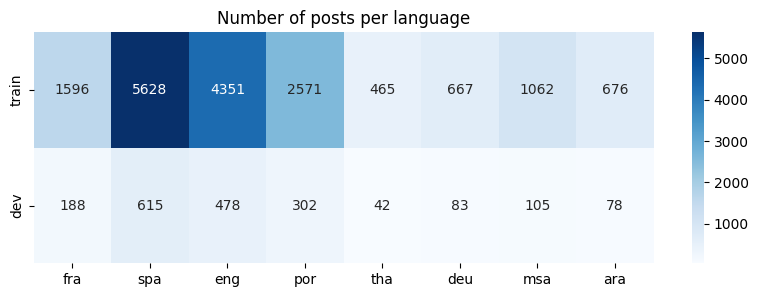

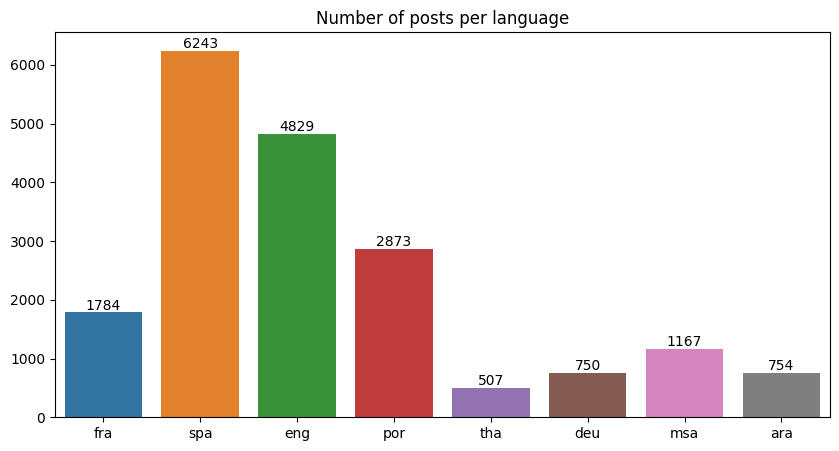

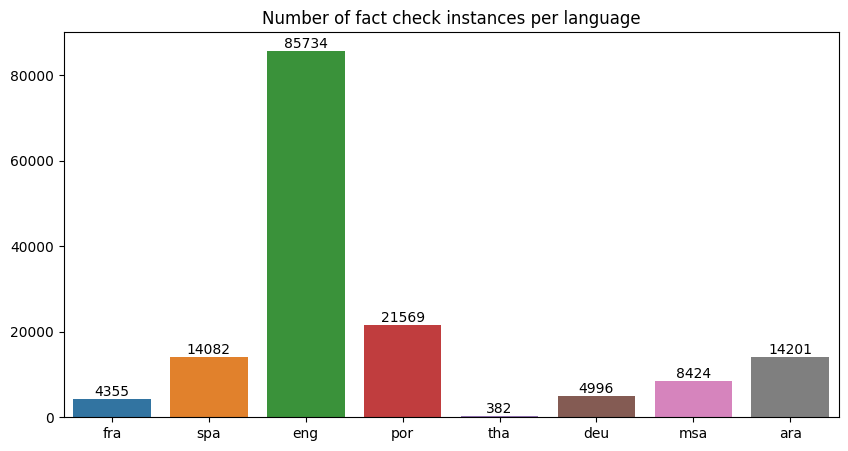

In [98]:
import collections

d_mono = posts.tasks["monolingual"]

d_posts = {}
d_fcs = {}
for lan in posts.langs:
    d_posts[lan] = {"train": [], "dev": [], "total": []}
    d_posts[lan]["train"].extend(d_mono[lan]["posts_train"])
    d_posts[lan]["dev"].extend(d_mono[lan]["posts_dev"])
    d_posts[lan]["total"] = d_posts[lan]["train"] + d_posts[lan]["dev"]
    
    d_fcs[lan] = {"fact_checks": []}
    d_fcs[lan]["fact_checks"].extend(d_mono[lan]["fact_checks"])
    
# Check if there are duplicates
for lan in d_posts:
    # print(f"Not overlapping posts for {lan}")
    assert len(d_posts[lan]["total"]) == len(set(d_posts[lan]["total"])), f"Duplicate posts found for {lan}"
    
    repeated = [item for item, count in collections.Counter(d_fcs[lan]["fact_checks"]).items() if count > 1]
    assert len(repeated) == 0, f"Duplicate fact checks found for {lan}"

df_posts_an = pd.DataFrame(d_posts)
df_out = df_posts_an.map(len)

df_fcs_an_0 = pd.DataFrame(d_fcs)
df_fcs_an = df_fcs_an_0.map(len)

# df_out = pd.concat([df_out, df_fcs_an], axis=0)

df_out["total"] = df_out.sum(axis=1)

plt.figure(figsize=(10, 3))
sns.heatmap(df_out.iloc[:-1, :-1], annot=True, fmt="d", cmap="Blues")
plt.title("Number of posts per language");

plt.figure(figsize=(10, 5))
sns.barplot(df_out.iloc[-1:, :-1])
plt.title("Number of posts per language");
for i in range(len(df_out.columns) -1):
    plt.text(i, df_out.iloc[-1, i], df_out.iloc[-1, i], ha='center', va='bottom')
    
plt.figure(figsize=(10, 5))
sns.barplot(df_fcs_an)
for i in range(len(df_fcs_an.columns)):
    plt.text(i, df_fcs_an.iloc[0, i], df_fcs_an.iloc[0, i], ha='center', va='bottom')
    
plt.title("Number of fact check instances per language")


/tmp/ipykernel_18375/1391291001.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), fontsize=18)
/tmp/ipykernel_18375/1391291001.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_yticklabels(ax1.get_yticks(), fontsize=10)


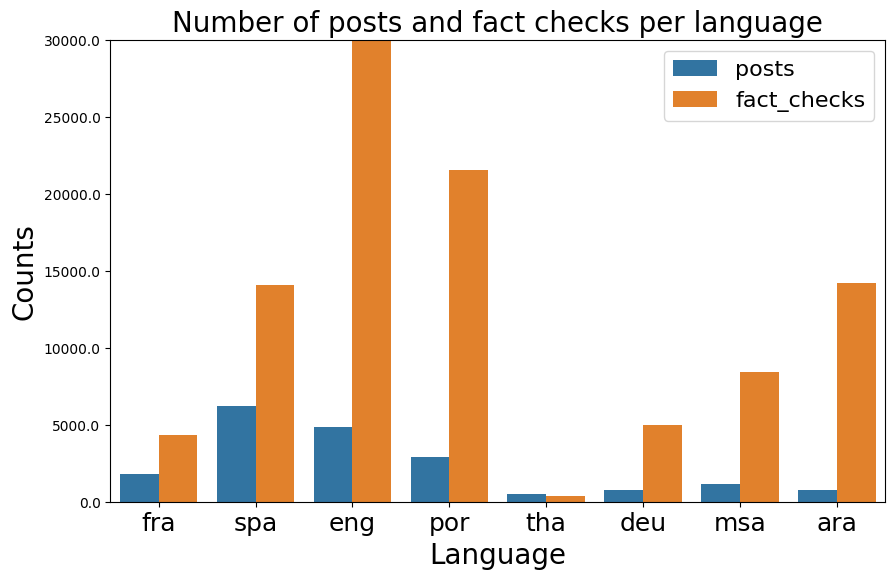

In [174]:
from tkinter import font


combined = pd.concat([df_out.iloc[-1:,:-1], df_fcs_an], axis=0).T
combined["lang"] = combined.index
combined.reset_index(drop=True, inplace=True)
combined.rename(columns={"total": "posts"}, inplace=True)
melted = pd.melt(combined, id_vars=["lang"], value_vars=["posts", "fact_checks"], var_name="type", value_name="counts")

fig, ax1 = plt.subplots(figsize=(10, 6))
g = sns.barplot(x="lang", y="counts", hue="type", data=melted, ax=ax1)
ax1.set_title("Number of posts and fact checks per language", fontsize=20)
ax1.set_ylabel("Counts", fontsize=20)
ax1.set_xlabel("Language", fontsize=20)
ax1.set_ylim(0, 30000)
ax1.set_xticklabels(ax1.get_xticklabels(), fontsize=18)
ax1.set_yticklabels(ax1.get_yticks(), fontsize=10)
plt.legend(fontsize=16)

plt.savefig("monolingual_stats.png")

Text(0.5, 1.0, 'Number of posts and fact checks per language')

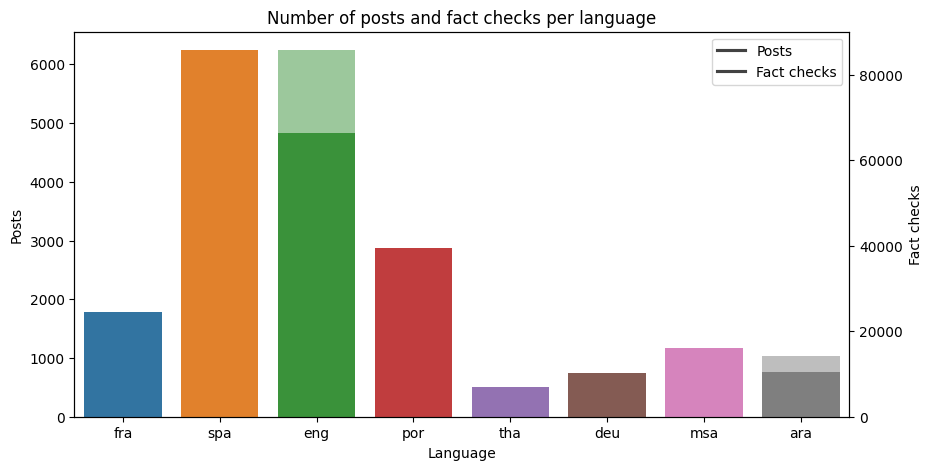

In [152]:
fig, ax1 = plt.subplots(figsize=(10, 5))
sns.barplot(df_out.iloc[-1:,:-1], ax=ax1)
ax1.set_ylabel("Posts")
ax1.set_xlabel("Language")

ax2 = ax1.twinx()
sns.barplot(df_fcs_an, ax=ax2, alpha=0.5)
ax2.set_ylabel("Fact checks")

plt.legend(["Posts", "Fact checks"])
plt.title("Number of posts and fact checks per language")

In [ ]:
df_out

,fra,spa,eng,por,tha,deu,msa,ara,total
train,1596,5628,4351,2571,465,667,1062,676,17016
dev,188,615,478,302,42,83,105,78,1891
total,1784,6243,4829,2873,507,750,1167,754,18907


In [142]:
df_fcs_an.sum(axis=1)

fact_checks    153743
dtype: int64

In [147]:
ls_fcs = df_fcs_an_0.sum(axis=1).iloc[0]
print("All of them different?", len(list(set(ls_fcs))) == len(ls_fcs))

All of them different? True


## Cross-lingual

In [141]:
d_cross = posts.tasks["crosslingual"]
print("Total:", len(d_cross["posts_train"] + d_cross["posts_dev"]))
print("Train:", len(d_cross["posts_train"]))
print("Dev:", len(d_cross["posts_dev"]))

print("Total fact checks:", len(d_cross["fact_checks"]))

Total: 5524
Train: 4972
Dev: 552
Total fact checks: 153743


# Example

In [32]:
sample_1 = df_train_en[(df_train_en["text"].str.split(" ").apply(len).between(3, 15))&(df_train_en["ocr"].str.split(" ").apply(len).between(3, 15))&(df_train_en["verdicts"] != "")].sample(1, random_state=100).iloc[:1, :]

print(sample_1.iloc[0].to_markdown())
print("\n")
print(df_fc.loc[sample_1["gs"].values[0]].iloc[0].to_markdown())


|           | 8626                                                                                              |
|:----------|:--------------------------------------------------------------------------------------------------|
| ocr       | odas Don't talk on the phone while on charge SUL                                                  |
| verdicts  | Missing context                                                                                   |
| text      | Do not talk on the phone, while it is charging!!                                                  |
| lan       | eng                                                                                               |
| fb        | 1                                                                                                 |
| tw        | 0                                                                                                 |
| ig        | 0                                                                         

In [ ]:
print(f"There are {len(posts)} posts")

There are 24431 posts


In [182]:
posts.df_train

,ocr,verdicts,text,lan,fb,tw,ig,full_text,gs
post_id,,,,,,,,,
2,"""Actually, he's a damn sight better than any o...",Missing context,,eng,2,0,0,"""Actually, he's a damn sight better than any o...",[93524]
5,"""Cigarette smoking does not cause cancer."" -Ce...",False information,,eng,1,0,0,"""Cigarette smoking does not cause cancer."" -Ce...",[33862]
13,"""Environmentalists"" Say Fracking is Evil 53-58...",Partly false information,,eng,1,0,0,"""Environmentalists"" Say Fracking is Evil 53-58...",[153628]
14,"""Environmentalists"" Say Fracking is Evil SAPER...",Partly false information,,eng,1,0,0,"""Environmentalists"" Say Fracking is Evil SAPER...",[153628]
15,"""Environmentalists"" Say Fracking is Evil This ...",Partly false information,,eng,2,0,0,"""Environmentalists"" Say Fracking is Evil This ...",[153628]
...,...,...,...,...,...,...,...,...,...
28044,COVID has killed 1.6M people in the world and ...,False information,🤦🏾 ♂️🙏🏾🙏🏾,eng,1,0,0,COVID has killed 1.6M people in the world and ...,[63100]
28048,,False information,🤩Why Every Judge On Shark Tank Backed This Pro...,eng,1,0,0,🤩Why Every Judge On Shark Tank Backed This Pr...,[119661]
28061,"Boris Johnson's dad, Stanley, wrote a novel in...",,🤷,eng,1,0,0,"Boris Johnson's dad, Stanley, wrote a novel in...",[32679]


In [37]:
sample_eng = posts.df_train
print(sample_eng[(sample_eng["ocr"] != "")&(sample_eng["text"].str.contains("Trump"))&(sample_eng["verdicts"] != "")&(sample_eng["gs"].apply(len) > 1)].sample(1, random_state=42).to_markdown())

|   post_id | ocr                                                                                                                                                                                                      | verdicts          | text                                                                                                       | lan   |   fb |   tw |   ig | full_text                                                                                                                                                                                                                                                                                                           | gs                      |
|----------:|:---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|:------------------|:----------------------------------------------------

In [40]:
len(posts.idx_train)

4351

In [48]:
20309 in posts.tasks["monolingual"]["eng"]["posts_train"]

True

In [49]:
sample_eng[sample_eng["lan"] == "other"]

,ocr,verdicts,text,lan,fb,tw,ig,full_text,gs
post_id,,,,,,,,,
213,1986-1992 910Mannu7 2009-2016 Ang madilim na k...,Partly false information,,other,1,0,0,1986-1992 910Mannu7 2009-2016 Ang madilim na k...,[102741]
3458,COVID-19 SYMPTOMS DAY 4 sore throat- hoarse-vo...,Partly false information,#MasMasayaSaBongabong #MalaluanCandelarioAdmin...,other,1,0,0,COVID-19 SYMPTOMS DAY 4 sore throat- hoarse-vo...,[72512]
3466,Maria Wirth [USER] - 18h Just wondering... Is ...,False information,#ModiHaiToMumkinHai #ModiHainTohMumkinHain,other,1,0,0,Maria Wirth [USER] - 18h Just wondering... Is ...,[104269]
3511,news24 Breaking News. First BREAKING: Vladamir...,False information,#NouMaakPuttinVirMalemaBaieKwaad!!! 😂😂😂,other,1,0,0,news24 Breaking News. First BREAKING: Vladamir...,[93679]
4007,Mount Lavinia Railway Station COLOMBO FORT RAI...,Partly false information,#චයිනීස්_ෆස්ට්😥😥😥,other,1,0,0,Mount Lavinia Railway Station COLOMBO FORT RAI...,[69213]
...,...,...,...,...,...,...,...,...,...
26576,DANGEROUS DI PALEVSKY HOW VAX REPRODUCTIVE SYS...,Partly false information,독신 쇼🧬 합법적 살인💰,other,1,0,0,DANGEROUS DI PALEVSKY HOW VAX REPRODUCTIVE SYS...,[95258]
26684,Reuters ✔ REUTERS [USER] South Korea's Moon se...,Partly false information,이 판국에도 북한에 백신지원 요청하는 바보가 한국 대통령 [URL],other,1,0,0,Reuters ✔ REUTERS [USER] South Korea's Moon se...,[121310]
26714,HEEL WEREY PRLSBAD www. DHAK 限定,,좆선아,other,1,0,0,HEEL WEREY PRLSBAD www. DHAK 限定 좆선아,[131858]


In [9]:
fact_checks_fra = TextConcatFactCheck(FACT_CHECKS_PATH, TASKS_PATH, task_name=TASK_NAME, lang="fra")
print(f"Loaded {len(fact_checks)}")

Loaded 4355


In [10]:
fact_checks.df

,claim,instances,title,full_text
fact_check_id,,,,
15,""" Il y a une vidéo qui sera lancée demain à Wh...",[https://www.20minutes.fr/high-tech/3216775-20...,WhatsApp : Une vidéo « Martinelli » qui va con...,WhatsApp : Une vidéo « Martinelli » qui va con...
136,"""1960 on n’était que 3% des femmes alphabétisé...",[http://africacheck.org/fr/fact-checks/article...,Fatou Sarr Sow se trompe sur le taux d’alphabé...,Fatou Sarr Sow se trompe sur le taux d’alphabé...
155,"""25% des effets secondaires liés aux vaccins s...",[https://www.liberation.fr/checknews/est-il-vr...,Est-il vrai que 25% des effets secondaires des...,Est-il vrai que 25% des effets secondaires des...
156,"""26 groupes armés"" ont rendu les armes dans la...",[https://factuel.afp.com/non-les-autorites-con...,"Non, les autorités congolaises n’ont pas enreg...","Non, les autorités congolaises n’ont pas enreg..."
187,"""5 % des élèves consomment de la drogue"".",[http://africacheck.org/fr/fact-checks/article...,Sénégal : 5 % des élèves consomment-ils de la ...,Sénégal : 5 % des élèves consomment-ils de la ...
...,...,...,...,...
156402,«Vous avez licencié 15 000 soignants [...] par...,[https://www.dna.fr/societe/2022/04/22/15-000-...,Désinfox 15 000 SOIGNANTS ONT-ILS ÉTÉ LICENCIÉ...,Désinfox 15 000 SOIGNANTS ONT-ILS ÉTÉ LICENCIÉ...
156686,À 74 ans elle donne naissance à un nouveau née,[https://factuel.afp.com/faux-ces-deux-images-...,"Faux, ces deux images n'ont aucun lien et ne m...","Faux, ces deux images n'ont aucun lien et ne m..."
156687,"À Hong Kong, des gens détruisent des tours de ...",[https://dpa-factchecking.com/belgium/220512-9...,Un lampadaire « intelligent » détruit par des ...,Un lampadaire « intelligent » détruit par des ...
